In [27]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
# Load Dataset
data = pd.read_csv('student_performance_data _.csv')
print(data.head())

# Assume 'GradeClass' as the target variable and exclude irrelevant columns
X = data.drop(columns=['StudentID', 'GradeClass'])  # Features
y = data['GradeClass']  # Target variable

# Handle missing values (if any)
X = X.fillna(0)
y = y.fillna(0)

# Convert categorical features to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Standardize the features (important for models like XGBoost)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

   StudentID  Age  Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  \
0       1001   17       1          0                  2        19.833723   
1       1002   18       0          0                  1        15.408756   
2       1003   15       0          2                  3         4.210570   
3       1004   17       1          0                  3        10.028829   
4       1005   17       1          0                  2         4.672495   

   Absences  Tutoring  ParentalSupport  Extracurricular  Sports  Music  \
0         7         1                2                0       0      1   
1         0         0                1                0       0      0   
2        26         0                2                0       0      0   
3        14         0                3                1       0      0   
4        17         1                3                0       0      0   

   Volunteering       GPA  GradeClass  
0             0  2.929196         2.0  
1             0  3

In [29]:
# Split the data into Training and Validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)


C:\Users\Keerthika Baktha\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:00] WARNING: D:\bld\xgboost-split_1727635034975\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

Validation Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.59      0.67        22
         1.0       0.86      0.86      0.86        49
         2.0       0.93      0.84      0.88        85
         3.0       0.87      0.88      0.88        86
         4.0       0.93      0.98      0.96       237

    accuracy                           0.91       479
   macro avg       0.87      0.83      0.85       479
weighted avg       0.91      0.91      0.91       479



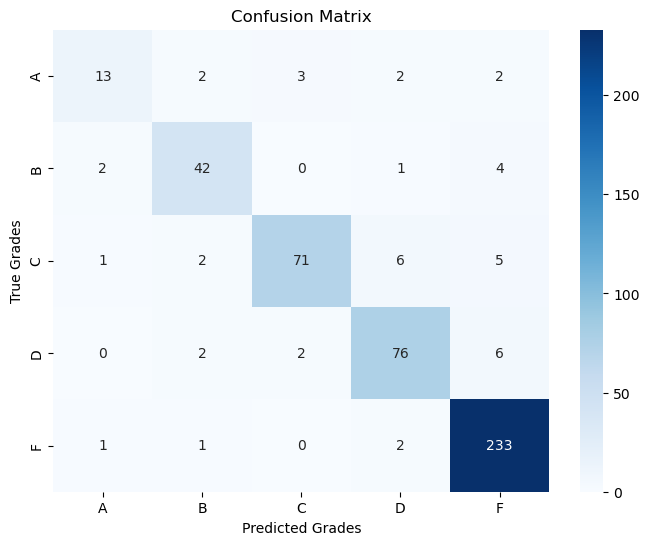

<Figure size 1000x600 with 0 Axes>

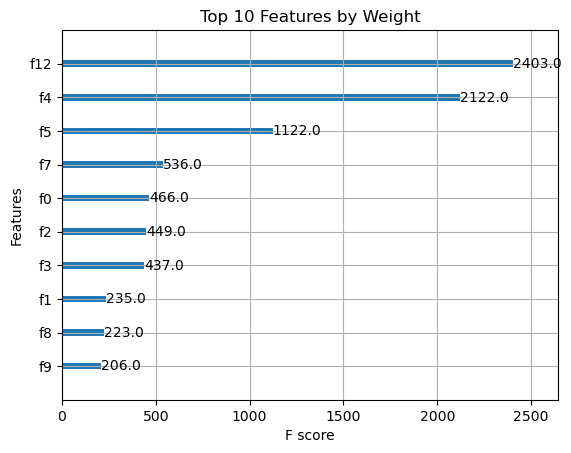

In [30]:
# Make predictions and evaluate the model
y_pred_val = xgb_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_val, y_pred_val))

# Confusion Matrix Plot
conf_matrix = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['A', 'B', 'C', 'D', 'F'], yticklabels=['A', 'B', 'C', 'D', 'F'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Grades")
plt.ylabel("True Grades")
plt.show()

# Feature Importance Plot
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, title="Top 10 Features by Weight")
plt.show()


In [31]:
# Function to predict GradeClass for user input
def predict_grade_class(input_data, model, scaler, feature_columns):
    """
    Predicts the GradeClass for a new student based on input features.

    Args:
    - input_data: List containing feature values for the student.
    - model: Trained model (XGBoost).
    - scaler: StandardScaler instance used for feature scaling.
    - feature_columns: List of feature column names.
    
    Returns:
    - Predicted GradeClass for the student.
    """
    # Convert input data to DataFrame
    input_df = pd.DataFrame([input_data], columns=feature_columns)
    
    # Standardize input features using the same scaler as the training data
    input_scaled = scaler.transform(input_df)
    
    # Predict GradeClass using the trained model
    predicted_class = model.predict(input_scaled)
    
    return predicted_class[0]


In [32]:
# Function to get user input
def get_user_input(feature_columns):
    """
    Prompts the user to enter feature values for a new student.
    
    Args:
    - feature_columns: List of feature names.
    
    Returns:
    - List of feature values entered by the user.
    """
    print("\nEnter the following details for the student:")
    user_input = []
    
    for feature in feature_columns:
        while True:
            try:
                value = float(input(f"Enter value for '{feature}': "))
                user_input.append(value)
                break
            except ValueError:
                print("Invalid input. Please enter a numeric value.")
    
    return user_input


In [ ]:
# Main program
if __name__ == "__main__":
    feature_columns = X.columns  # List of feature columns from the dataset
    user_input = get_user_input(feature_columns)
    
    # Predict GradeClass for user input
    predicted_grade = predict_grade_class(user_input, xgb_model, scaler, feature_columns)
    
    # Map predicted GradeClass to readable grades
    grade_mapping = {
        0: 'A (GPA >= 3.5)',
        1: 'B (3.0 <= GPA < 3.5)',
        2: 'C (2.5 <= GPA < 3.0)',
        3: 'D (2.0 <= GPA < 2.5)',
        4: 'F (GPA < 2.0)'
    }
    
    print(f"\nThe predicted GradeClass for the student is: {grade_mapping[predicted_grade]}")



Enter the following details for the student:
